# SAS ODA and Python Integration to Analyze COVID-19 Data

The purpose of this notebook is to illustrate how Python code can be integrated with calls to SAS ODA in order to solve a particular problem of interest. In the course of this document, we will load the NYT COVID-19 data set. As the NYT data set contains raw cumulative values only, we will also load a census data set that contains estimates for the US population in 2019. We will combine the information from both data sets to calculate the number of cases and deaths per 1,000,000 residents of each state on each day for which we have data. Afterwards, we will use a few different techniques to visualize the cases per 100,000 for the various states.

## NYT Data Acquisition 

Our first step is to start a connection with the SAS servers. We use the "SASPy" Python package (installed locally) and its [`SASsession` method](https://sassoftware.github.io/saspy/api.html#saspy.SASsession) to establish this connection. 

In [1]:
import saspy

sas_session = saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 10288



With the connection established, we can use the [`submit` method](https://sassoftware.github.io/saspy/api.html#saspy.SASsession.submit) to run SAS code from our Python interface. This method returns the SAS output and log message as a Python dictionary which can then be queried for either component.

In [2]:
results_dict = sas_session.submitLST(
             """
                filename nyt_url url 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv';
                data us_counties_nyt;
                    length Date 8 County $ 30 statename $ 30 FIPS $ 6 Cases 8 Deaths 8 WeekOf 8;
                    format Date date9. WeekOf date9.;
                    infile nyt_url dlm=',' missover dsd firstobs=2;
                    input date : yymmdd10.
                        county
                        statename
                        FIPS
                        cases
                        deaths;
                    /* Adding Week ending value for easier summary later */
                    WeekOf = intnx('week',date,0,'E');
                run;
             """,
             )

To view the SAS log of the previous operation, you would run the command ```print(results_dict["LOG"])``` in Python. 

SAS has a built-in data set with information about the US, including the 2-letter state codes. We will use an inner join method using a `proc sql` in SAS to attach this 2-letter code to our data rows. We specifically use an inner join as the NYT data set includes data on some US territories which we wish to exclude from our analysis in order to focus only on the US states.

In the last line, we use the [`sd2df` method](https://sassoftware.github.io/saspy/api.html#saspy.SASsession.sd2df) on our SAS session to move the data from SAS to Python for further processing.

In [3]:
results_dict = sas_session.submit(
             """
            proc sql noprint;
             create table NYT_joined as
                select nyt.Date, nyt.County, nyt.statename as State, usd.Statecode as StateCode, nyt.Cases, nyt.Deaths
                from work.US_COUNTIES_NYT as nyt inner join sashelp.us_data as usd
                on nyt.statename=usd.statename;
            quit;
             """,
             )

nyt_df = sas_session.sd2df("NYT_joined")

Now that we have the data available in Python, we will load the various Python packages we will need.

In [4]:
# this is for type-hinting in function definitions:
from typing import List, Dict  

# some standard imports from Python for this 
# type of work
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# some nice imports to make life easier
# 1) make matplotlib aware of Pandas DateTime format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# 2) create nicer date formatting in plots
import matplotlib.dates as mdates

Since the source data set we imported lists data from various counties separately, we first want to simplify our work by adding up all the cases and deaths in each state so that we have only one row of data per state per date. Since this is a common class of problem, we will write a small function to do this task for us. This method is similar to writing and using a macro in SAS.

In [5]:
def make_state_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to process the initial data in two ways:
    1) Filter down the columns to the important ones, dropping
       columns that we don't need for our analysis. 
    2) Each state is broken down into counties in the NYT data set,
       but we want state level information. We sum across the counties
       in the state.
    Overall, this function is comparable to a "proc freq"
    in SAS.
    """
    
    # filter out unnecessary information. Think of a SAS 'keep' statement.
    df = df.filter(['Date', 'State','Cases','Deaths', 'StateCode'])
    
    # sums up the data by 'Date', 'State, 'Statecode',
    # - this returns state-level 'cases' and 'deaths'
    short = df.groupby(['Date', 'State', 'StateCode'],
                        as_index=False).sum()
    return short

# call our function to apply the manipulation from the 
# `make_state_summary` function.
df = make_state_summary(nyt_df)

Let's verify the data types to make sure we have everything we need. It is important that the Date variable is listed as ```datetime64[ns]``` as opposed to as ```object```, which is a string format as opposed to the numeric date format we want. If this variable is listed as an object, we can run the line ```df.Date = pd.to_datetime(df.Date)``` to fix this problem. We run the conditional fix and print the data types of all columns to make sure we have the correct types for further analysis.

In [6]:
# verify that Date is not a string format,
# fix it otherwise.
if df["State"].dtype==df["Date"].dtype:
    df.Date = pd.to_datetime(df.Date)
    
df.dtypes

Date         datetime64[ns]
State                object
StateCode            object
Cases                 int64
Deaths              float64
dtype: object

## Updating our Data Set with the Census Information

Since we ultimately want to figure out the number of cases  and deaths per 100,000 residents of each state, we use a data set from the census bureau which includes population estimates for 2019. We use the `filter` method (similar to a `keep` in SAS) to only load the columns we are interested in, including the actual values from the 2010 census, as well as the Census Bureau's estimates for the year 2019.

In [7]:
census_url = "http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#"
pop_set = pd.read_csv(census_url).filter(['REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
                          'ESTIMATESBASE2010', 'POPESTIMATE2019'])

Now that we have both data sets available in memory, we will calculate the case-load and death-toll for each state and date given the 2019 estimate. The calculated values are appended as new columns to our data set.

In [8]:
def update_case_load(source : pd.DataFrame, 
                    census : pd.DataFrame) -> pd.DataFrame:
    """
    Function to update a dataframe to include case-load
    and death-toll per 100,000 residents using a census
    data set as look-up table for population values.
    """
    
    # for loop iterates over all rows in the 'source' dataframe
    for index, row in source.iterrows():
        state = row["State"]  # looks-up current statename of row
        # then looks-up the "POPESTIMATE2019" column value associated with 
        # that state in the `census` dataframe. 
        pop = census[census.NAME==state]["POPESTIMATE2019"].to_numpy()[0]
        
        # use the population value to calculate cases/deaths per 100.000 residents
        cases_per_100k = 1e5*row["Cases"]/pop
        deaths_per_100k = 1e5*row["Deaths"]/pop
        
        # update `source` dataframe with three new column values
        source.loc[index,"Population"] = pop
        source.loc[index,"CPM"] = cases_per_100k
        source.loc[index, "DPM"] = deaths_per_100k
    return source

# run the functon to actually apply the calculations
# defined in the `update_case_load` function.
df = update_case_load(df, pop_set)

At this stage, we have two Pandas dataframes in memory - the `pop_set` dataframe which was used a look-up table for state population information, and the main dataframe `df` which contains the following columns of information we want for our visualizations:

In [9]:
df.dtypes

Date          datetime64[ns]
State                 object
StateCode             object
Cases                  int64
Deaths               float64
Population           float64
CPM                  float64
DPM                  float64
dtype: object

## Simple Plot Visualition

Let's start with a few simple visualizations to compare different states. To make it easier, we create a short function that subsets the necessary data, followed by a short function to do the plotting with the output data set.

In [10]:
def state_sets(df : pd.DataFrame, States: List) -> Dict:
    """
    This function is similar to a data step in SAS. It takes
    in a list of state-codes of interest together with the main
    dataframe and returns a dictionary where each statecode is mapped
    to a dataframe containing only the information from that state.
    """
    # use a quick dictionary comprehension to subset the data
    out_dict = {state : df[df.StateCode==state] for state in States }
    return out_dict

def line_plot_states(states_of_interest : Dict,
                    min_date : str = "2020-03-01"):
    """
    Convenience function to do the plotting.
    Takes a dictionary of states and a start date and then 
    makes a line plot of the 'cases per 100,000' variable in
    all states listed in the dictionary.
    """
    # define plot size
    fig, ax = plt.subplots(figsize=(10,5.625))
    
    # iterates over the dictionary and adds each state's 
    # line to the plot
    for key, data in states_of_interest.items():
        subdata = data[data.Date>=pd.to_datetime(min_date)]
        ax.plot(subdata.Date, subdata.CPM, label=key)
    ax.legend() # turns on the legend

    # make the axes pretty
    fig.autofmt_xdate()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_ylabel('Cases per 100,000')

    plt.show(fig) # necessary to display the plot

 Now all we need to do is to create a list of states of interest and pass them to our function, along with an optional start date. Say we are interested in comparing the cases per 100,000 residents over time for several different states. Then our code would look as follows:

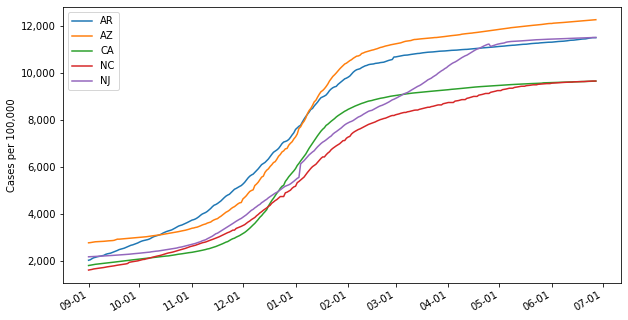

In [11]:
# list of states, sort it so that the legend is alphabetical
# Try out different states!
state_list = sorted(["AZ", "CA", "NC", "NJ", "AR"])

# get the dictionary of state data out
states_of_interest = state_sets(df, state_list)

# does the plotting
line_plot_states(states_of_interest, "2020-09-01")

## Making the Map

Making maps and plotting over them is hard. Luckily, SAS has a few special procedures available for this. To make our work easier, we will first collect the necessary information for the map from our Python data set and then export it to SAS for plotting. We'll pick data corresponding to a single date and upload the data set to SAS. 

In [12]:
# list of dates of interest
# note that the SAS code below expects only one date,
# so if you choose to make a list of multiple dates here,
# please also update the SAS code below to pick a specific
# date for plotting.
# Use format 'YYYY-MM-DD' for the dates
dates_of_interest = ["2021-06-01"]

# uses the above list to subset the dataframe
sub_df = df[df.Date.isin(dates_of_interest)]

# uploads the dataframe to SAS under the name
# work.map_data
sas_session.df2sd(sub_df, table="map_data")

Libref  = WORK
Table   = map_data
Dsopts  = {}
Results = Pandas

We first want to make a choropleth map of the situation. This would allow us to use a color scheme to differentiate between different classes of states, based on the CPM value. Well, `gmap` to the rescue. We will use the `midpoints=old` to use a the Nelder algorithm to determine the appropriate ranges and midpoints.

In [13]:
%%SAS sas_session

proc gmap data=work.map_data map=mapsgfk.us all;
    id STATECODE;
    format CPM COMMA10.;
    choro CPM / midpoints=old;
run;

By changing the code slightly, we can also create a gradient map of cases.


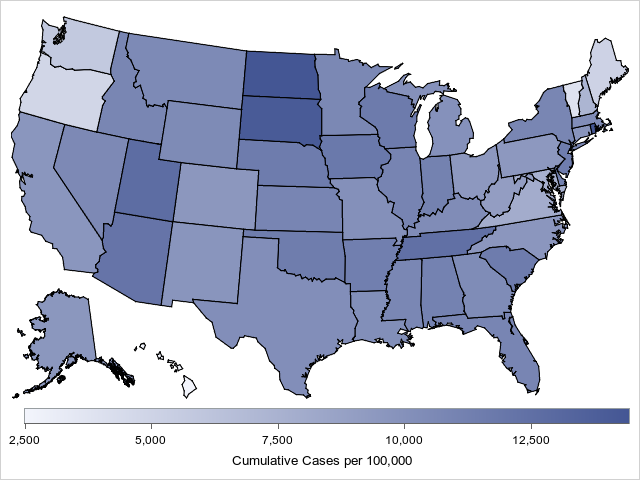

In [14]:
%%SAS sas_session

proc sgmap mapdata=mapsgfk.us maprespdata=map_data;
    choromap cpm / mapid=statecode name='choro';
    format cpm COMMA10.;
    gradlegend 'choro' / title='Cumulative Cases per 100,000' extractscale;
run;
